In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
# Filter test for store = 0 and product =0
test = test[(test['store'] == 0) & (test['product'] == 0)]

# Filter train for store = 0 and product =0
train = train[(train['store'] == 0) & (train['product'] == 0)]



In [4]:
# combine train and test and call it diff_data
diff_data = pd.concat([train, test])

In [5]:
# Convert diff data to numpy array of number_sold
diff_data = np.diff(diff_data['number_sold'].values)

In [6]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def train_validate_test_split(data, train_size=0.7, val_size=0.15):
    n = len(data)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    return train_data, val_data, test_data

train_data, val_data, test_data = train_validate_test_split(diff_data)

scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1, 1))

train_data = scaler.transform(train_data.reshape(-1, 1)).flatten()
val_data = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()

In [7]:
sequence_length = 50  # Example sequence length

X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = X_train.reshape(-1, sequence_length, 1)
X_val = X_val.reshape(-1, sequence_length, 1)
X_test = X_test.reshape(-1, sequence_length, 1)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [8]:
class CombinedElmanJordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.0):
        super(CombinedElmanJordanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size

        # Elman layer
        self.elman_rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, dropout=dropout)
        
        # Jordan layer
        self.jordan_rnn = nn.RNN(hidden_size + output_size, hidden_size, num_layers=1, batch_first=True, dropout=dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        sequence_length = x.size(1)

        # Initial hidden states
        h0_elman = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        h0_jordan = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        # Initial output for Jordan layer
        jordan_output = torch.zeros(batch_size, 1, self.fc.out_features).to(x.device)

        outputs = []

        for t in range(sequence_length):
            # Elman layer
            elman_out, h0_elman = self.elman_rnn(x[:, t:t+1, :], h0_elman)
            
            # Combine Elman output with previous Jordan output
            combined_input = torch.cat((elman_out, jordan_output), dim=2)
            
            # Jordan layer
            jordan_out, h0_jordan = self.jordan_rnn(combined_input, h0_jordan)
            
            # Output layer
            output = self.fc(jordan_out)
            outputs.append(output)
            
            # Update Jordan output for next iteration
            jordan_output = output

        # Stack outputs
        outputs = torch.cat(outputs, dim=1)
        return outputs[:, -1, :]  # Return only the last time step

input_size = 1
hidden_size = 64  # Adjust as needed
output_size = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 20
batch_size = 64

In [9]:
# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
model = CombinedElmanJordanRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_losses.append(loss.item())
        model.train()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}')

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/20, Train Loss: 0.0305, Val Loss: 0.0199
Epoch 2/20, Train Loss: 0.0183, Val Loss: 0.0174
Epoch 3/20, Train Loss: 0.0163, Val Loss: 0.0153
Epoch 4/20, Train Loss: 0.0147, Val Loss: 0.0136
Epoch 5/20, Train Loss: 0.0139, Val Loss: 0.0129
Epoch 6/20, Train Loss: 0.0136, Val Loss: 0.0127
Epoch 7/20, Train Loss: 0.0134, Val Loss: 0.0126
Epoch 8/20, Train Loss: 0.0132, Val Loss: 0.0122
Epoch 9/20, Train Loss: 0.0131, Val Loss: 0.0133
Epoch 10/20, Train Loss: 0.0128, Val Loss: 0.0121
Epoch 11/20, Train Loss: 0.0128, Val Loss: 0.0125
Epoch 12/20, Train Loss: 0.0129, Val Loss: 0.0123
Epoch 13/20, Train Loss: 0.0123, Val Loss: 0.0145
Epoch 14/20, Train Loss: 0.0133, Val Loss: 0.0125
Epoch 15/20, Train Loss: 0.0126, Val Loss: 0.0121
Epoch 16/20, Train Loss: 0.0130, Val Loss: 0.0183
Epoch 17/20, Train Loss: 0.0149, Val Loss: 0.0130
Epoch 18/20, Train Loss: 0.0133, Val Loss: 0.0127
Epoch 19/20, Train Loss: 0.0136, Val Loss: 0.0131
Epoch 20/20, Train Loss: 0.0130, Val Loss: 0.0132


In [12]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)

predictions, actuals = predict(model, test_loader)

# Reshape for inverse transform
predictions = predictions.reshape(-1, 1)
actuals = actuals.reshape(-1, 1)

predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

In [15]:
import numpy as np

mse = np.mean((np.array(actuals_inv) - np.array(predictions_inv))**2)
mae = np.mean(np.abs(np.array(actuals_inv) - np.array(predictions_inv)))
print(f'Test MSE: {mse:.4f}, Test MAE: {mae:.4f}')

Test MSE: 129.2431, Test MAE: 8.8901


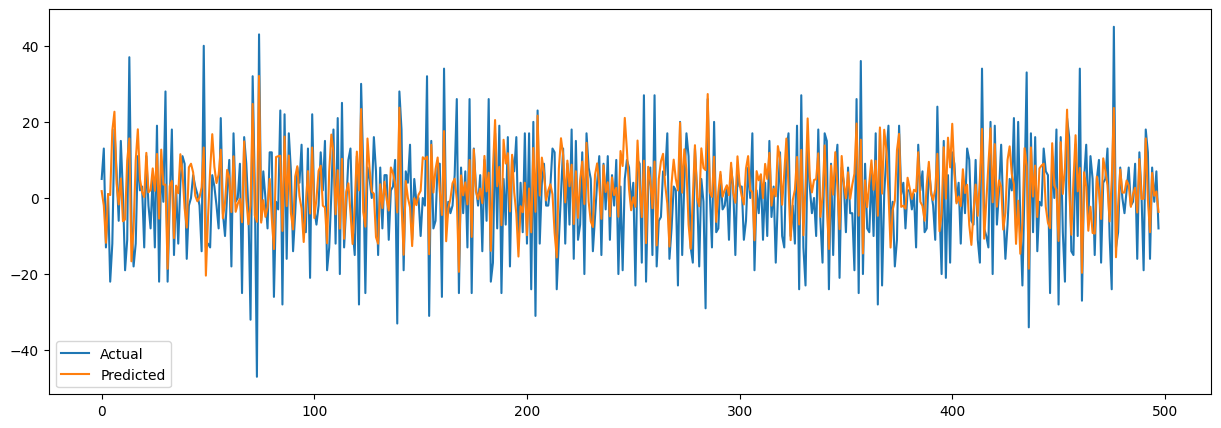

In [14]:
plt.figure(figsize=(15,5))
plt.plot(actuals_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.show()

In [16]:
import numpy as np

mse = np.mean((np.array(actuals_inv) - np.array(predictions_inv))**2)
mae = np.mean(np.abs(np.array(actuals_inv) - np.array(predictions_inv)))
print(f'Test MSE: {mse:.4f}, Test MAE: {mae:.4f}')

Test MSE: 129.2431, Test MAE: 8.8901
